In [ ]:
import torch
import numpy as np
import pandas as pd
from torch import nn
torch.__version__

'2.8.0+cu126'

In [ ]:
import sklearn
from sklearn.datasets import make_circles
n_samples = 1000
X , y = make_circles(n_samples , noise= 0.03 , random_state=42)

In [ ]:
circles = pd.DataFrame({'X1':X[: , 0] , 'X2':X[: , 1],'y':y})

In [ ]:
circles.head()

,X1,X2,y
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


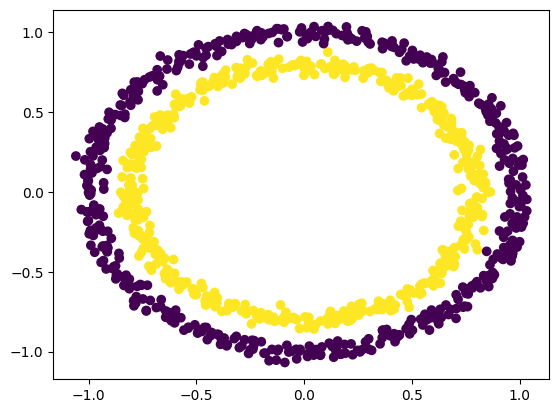

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(X[: , 0],X[: , 1],c=y )

In [ ]:
print(X.shape)
print(y.shape)

(1000, 2)
(1000,)


In [ ]:
first_sample_X = X[0]
first_sample_y = y[0]
print(f'X : {first_sample_X} y : {first_sample_y}  X shape : {first_sample_X.shape} y shape : {first_sample_y.shape}')

X : [0.75424625 0.23148074] y : 1  X shape : (2,) y shape : ()


In [ ]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
y.dtype

torch.float32

In [ ]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(X , y , train_size= 0.8 , random_state=42)

In [ ]:
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class ToyClassificationV0 (nn.Module) :
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2 , out_features=5)
    self.layer_2 = nn.Linear(in_features=5 , out_features=1)
  def forward(self , x):
     return self.layer_2(self.layer_1(x))
model_0 = ToyClassificationV0().to(device)

In [ ]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.6580, -0.2720],
                      [ 0.6845,  0.3472],
                      [-0.1781,  0.2072],
                      [ 0.4328, -0.0208],
                      [-0.4673, -0.6118]])),
             ('layer_1.bias',
              tensor([ 0.5672,  0.4899,  0.5258,  0.0896, -0.2559])),
             ('layer_2.weight',
              tensor([[-0.3253,  0.2853,  0.4446, -0.0374,  0.1691]])),
             ('layer_2.bias', tensor([0.2539]))])

In [ ]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2 , out_features=5),
    nn.Linear(in_features=5 , out_features=1)
).to(device)

In [ ]:
with torch.inference_mode():
  untrained_pred = model_0(X_test.to(device))
print(f' untrained_pred : {len(untrained_pred)} untrained_pred.shape : {untrained_pred.shape}')
print(f' y_test : {len(y_test)} y_test.shape : {y_test.shape}')
print(untrained_pred)
print(y_test)

 untrained_pred : 200 untrained_pred.shape : torch.Size([200, 1])
 y_test : 200 y_test.shape : torch.Size([200])
tensor([[0.2536],
        [0.2930],
        [0.2686],
        [0.2489],
        [0.4564],
        [0.4790],
        [0.4411],
        [0.4851],
        [0.2607],
        [0.2977],
        [0.2332],
        [0.2740],
        [0.4692],
        [0.3021],
        [0.2339],
        [0.4676],
        [0.3641],
        [0.2067],
        [0.2333],
        [0.2006],
        [0.2909],
        [0.5117],
        [0.2270],
        [0.1895],
        [0.3969],
        [0.4583],
        [0.3775],
        [0.5089],
        [0.2219],
        [0.3302],
        [0.4108],
        [0.3856],
        [0.2386],
        [0.4130],
        [0.2248],
        [0.3196],
        [0.2608],
        [0.2909],
        [0.3887],
        [0.3148],
        [0.2221],
        [0.2434],
        [0.3675],
        [0.4676],
        [0.2346],
        [0.3292],
        [0.4808],
        [0.2848],
        [0.3119],
     

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_0.parameters(),lr = 0.01)

In [ ]:
def ac_fn(y_true , y_predict):
  corroct = torch.eq(y_true,y_predict).sum().item()
  acc = (corroct/len(y_true))*100
  return acc

In [ ]:
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))
    new_pred = torch.sigmoid(y_logits)
    y_pred = torch.round(new_pred)
y_pred = torch.round(torch.sigmoid(model_0(X_test.to(device))))

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
X_train , y_train , X_test , y_test = X_train.to(device) , y_train.to(device) , X_test.to(device) , y_test.to(device)
epochs = 500
for epoch in range(epochs):
  model_0.train()
  y_predicted_logits = model_0(X_train).squeeze()
  y_predicted = torch.round(torch.sigmoid(y_predicted_logits))
  loss = loss_fn(y_predicted_logits , y_train)
  acc = ac_fn(y_true= y_train , y_predict = y_predicted)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  model_0.eval()
  with torch.inference_mode():
    test_predict = model_0(X_test).squeeze()
    test_predicted = torch.round(torch.sigmoid(test_predict))
    test_loss = loss_fn(test_predict , y_test)
    test_acc = ac_fn(y_true= y_test , y_predict = test_predicted)
  if epoch % 10 == 0:
    print(f"Epoch {epoch}: Loss = {loss.item():.4f}, Accuracy = {acc:.4f}, Test loss = {test_loss:.4f}, Test Accuracy = {test_acc:.2f}")




Epoch 0: Loss = 0.7098, Accuracy = 50.0000, Test loss = 0.7094, Test Accuracy = 50.00
Epoch 10: Loss = 0.7082, Accuracy = 50.0000, Test loss = 0.7081, Test Accuracy = 50.00
Epoch 20: Loss = 0.7068, Accuracy = 50.0000, Test loss = 0.7070, Test Accuracy = 50.00
Epoch 30: Loss = 0.7055, Accuracy = 50.0000, Test loss = 0.7060, Test Accuracy = 50.00
Epoch 40: Loss = 0.7043, Accuracy = 50.0000, Test loss = 0.7051, Test Accuracy = 50.00
Epoch 50: Loss = 0.7033, Accuracy = 50.0000, Test loss = 0.7043, Test Accuracy = 50.00
Epoch 60: Loss = 0.7023, Accuracy = 50.0000, Test loss = 0.7036, Test Accuracy = 50.00
Epoch 70: Loss = 0.7015, Accuracy = 50.0000, Test loss = 0.7030, Test Accuracy = 50.00
Epoch 80: Loss = 0.7007, Accuracy = 50.0000, Test loss = 0.7024, Test Accuracy = 50.00
Epoch 90: Loss = 0.7000, Accuracy = 50.0000, Test loss = 0.7019, Test Accuracy = 50.00
Epoch 100: Loss = 0.6994, Accuracy = 50.0000, Test loss = 0.7014, Test Accuracy = 50.00
Epoch 110: Loss = 0.6989, Accuracy = 50.000

In [ ]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
  print('helper_functions.py ok')
else :
    print("helper_functions.py not ok, downloading...")
    url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py"
    response = requests.get(url)

    if response.status_code == 200:
        with open("helper_functions.py", "wb") as f:
            f.write(response.content)
        print("Downloaded helper_functions.py successfully ✅")
    else:
        print(f"Failed to download. Status code: {response.status_code}")

helper_functions.py not ok, downloading...
Downloaded helper_functions.py successfully ✅


In [ ]:
from helper_functions import plot_decision_boundary , plot_predictions

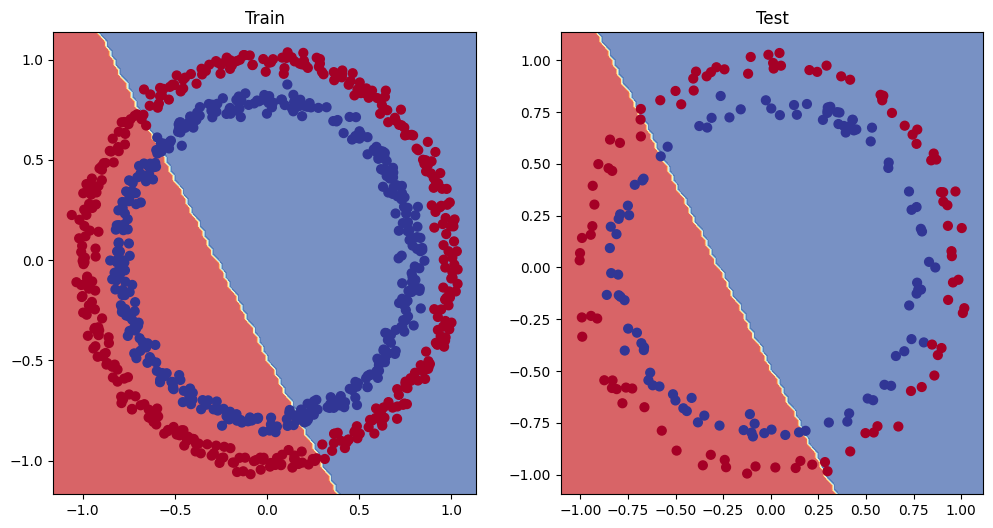

In [ ]:
plt.figure(figsize = (12 , 6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0,X_test,y_test)

In [ ]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2 , out_features=10)
    self.layer_2 = nn.Linear(in_features=10 , out_features=10)
    self.layer_3 = nn.Linear(in_features=10 , out_features=1)
  def forward(self , x):
    return   self.layer_3(self.layer_2(self.layer_1(x)))
model_1 = CircleModelV2()
model_1 = model_1.to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters() , lr= 0.1)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
X_train , y_train , X_test , y_test = X_train.to(device) , y_train.to(device) , X_test.to(device) , y_test.to(device)
epochs = 1000
for epoch in range(epochs):
  model_1.train()
  y_logits= model_1(X_train).squeeze()
  y_predict = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_predict , y_train)
  acc = ac_fn(y_true= y_train , y_predict = y_predict)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  model_1.eval()
  with torch.inference_mode():
    yy = model_1(X_test).squeeze()
    yyy = torch.round(torch.sigmoid(yy))
    test_loss = loss_fn(yyy , y_test)
    acc_test = ac_fn(y_true= y_test , y_predict = yyy)
  if epoch % 100 == 0:
    print(f"Epoch {epoch}: Loss = {loss.item():.4f}, Accuracy = {acc:.4f}, Test loss = {test_loss:.4f}, Test Accuracy = {acc_test:.2f}")


Epoch 0: Loss = 0.7577, Accuracy = 50.8750, Test loss = 0.7554, Test Accuracy = 51.00
Epoch 100: Loss = 0.7577, Accuracy = 50.8750, Test loss = 0.7554, Test Accuracy = 51.00
Epoch 200: Loss = 0.7577, Accuracy = 50.8750, Test loss = 0.7554, Test Accuracy = 51.00
Epoch 300: Loss = 0.7577, Accuracy = 50.8750, Test loss = 0.7554, Test Accuracy = 51.00
Epoch 400: Loss = 0.7577, Accuracy = 50.8750, Test loss = 0.7554, Test Accuracy = 51.00
Epoch 500: Loss = 0.7577, Accuracy = 50.8750, Test loss = 0.7554, Test Accuracy = 51.00
Epoch 600: Loss = 0.7577, Accuracy = 50.8750, Test loss = 0.7554, Test Accuracy = 51.00
Epoch 700: Loss = 0.7577, Accuracy = 50.8750, Test loss = 0.7554, Test Accuracy = 51.00
Epoch 800: Loss = 0.7577, Accuracy = 50.8750, Test loss = 0.7554, Test Accuracy = 51.00
Epoch 900: Loss = 0.7577, Accuracy = 50.8750, Test loss = 0.7554, Test Accuracy = 51.00


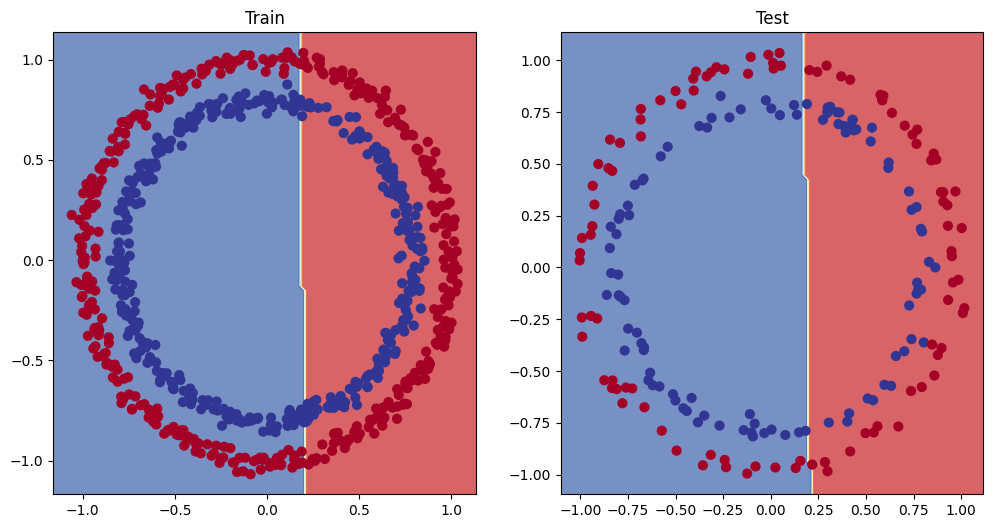

In [ ]:
plt.figure(figsize = (12 , 6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_1,X_test,y_test)

In [ ]:
X2 = torch.arange(1,20,0.2).unsqueeze(dim=1)
weight = 0.7
bias = 2
y2= X2 * 0.7 + 2
data_split = int(0.8*len(X2))
X_train_2 , y_train_2 , X_test_2 , y_test_2 = X2[:  data_split] , y2[:  data_split] , X2[data_split  :] , y2[data_split  :]

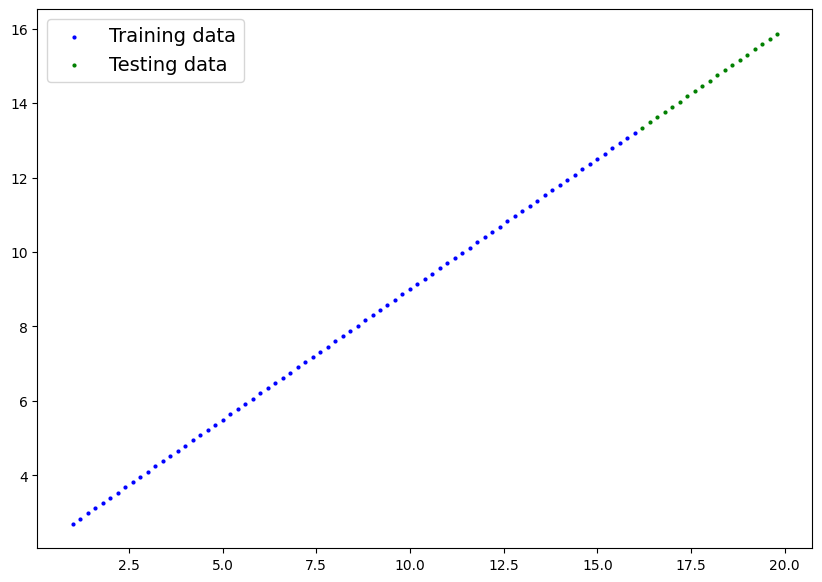

In [ ]:
plot_predictions(train_data = X_train_2 , train_labels = y_train_2 , test_data= X_test_2 , test_labels = y_test_2)

In [ ]:
model_2 = nn.Sequential(
   nn.Linear(in_features=1 , out_features=10),
   nn.Linear(in_features=10 , out_features=10),
   nn.Linear(in_features=10 , out_features=1)
).to(device)
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(),lr = 0.01)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
X_train_2 = X_train_2.unsqueeze(1)
X_test_2  = X_test_2.unsqueeze(1)
y_train_2 = y_train_2.unsqueeze(1)
y_test_2  = y_test_2.unsqueeze(1)
X_train_2 , y_train_2 , X_test_2 , y_test_2 = X_train_2.to(device) , y_train_2.to(device) , X_test_2.to(device) , y_test_2.to(device)
epochs = 1000
for epoch in range(epochs):
  model_2.train()
  y_predict = model_2(X_train_2)
  loss = loss_fn(y_predict , y_train_2)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  model_2.eval()
  with torch.inference_mode():
    y_test_predicted = model_2(X_test_2)
    test_loss = loss_fn(y_test_predicted , y_test_2)
  if epoch % 100 == 0:
    print(f"Epoch {epoch}: Loss = {loss.item():.4f} , Test loss = {test_loss:.4f}")

Epoch 0: Loss = 5.6063 , Test loss = 3.5170
Epoch 100: Loss = 1.5749 , Test loss = 0.5739
Epoch 200: Loss = 0.9943 , Test loss = 1.3963
Epoch 300: Loss = 0.3094 , Test loss = 2.5894
Epoch 400: Loss = 0.6652 , Test loss = 2.1336
Epoch 500: Loss = 0.9124 , Test loss = 1.1516
Epoch 600: Loss = 0.5264 , Test loss = 2.2654
Epoch 700: Loss = 0.7963 , Test loss = 1.1807
Epoch 800: Loss = 1.3685 , Test loss = 0.4294
Epoch 900: Loss = 0.1710 , Test loss = 2.6727


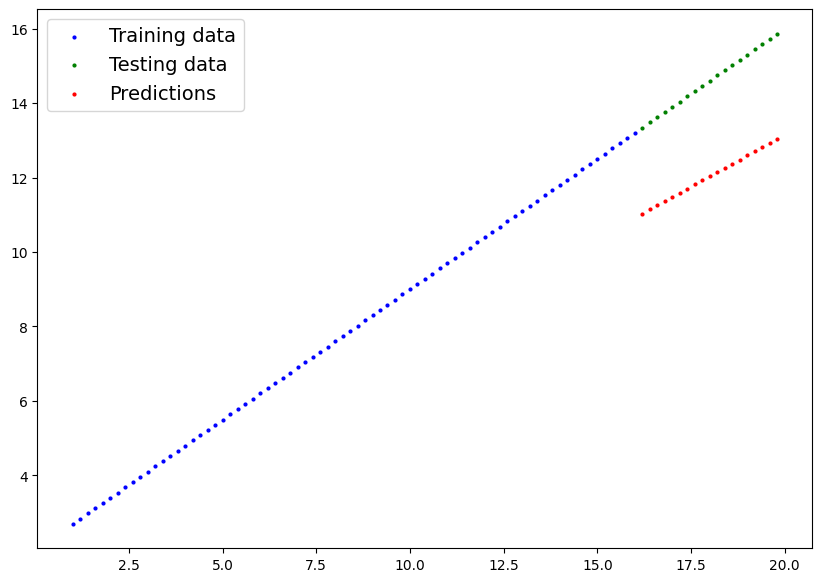

In [ ]:
plot_predictions(
    train_data = X_train_2.cpu(),
    train_labels = y_train_2.cpu(),
    test_data = X_test_2.cpu(),
    test_labels = y_test_2.cpu(),
    predictions = y_test_predicted.cpu()
)

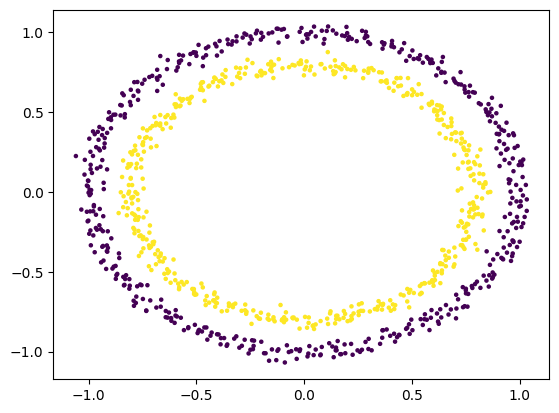

In [ ]:
X , y = make_circles(1000,noise=0.03 , random_state=42)
X , y = torch.from_numpy(X).type(torch.float),torch.from_numpy(y).type(torch.float)
X_train , X_test , y_train , y_test = train_test_split(X , y , train_size=0.8 ,random_state=42)
plt.scatter(X[:, 0], X[:, 1], s=5, c=y)


In [ ]:
from torch import nn
class CircleModelV3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV3().to(device)
print(model_3)

CircleModelV3(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [ ]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [ ]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = ac_fn(y_train,
                     y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = ac_fn(y_test,
                             test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


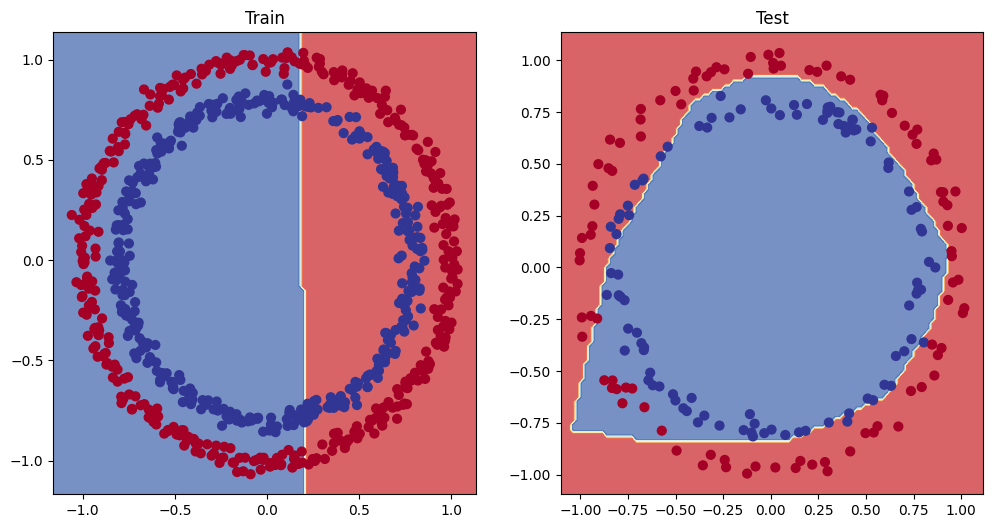

In [ ]:

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

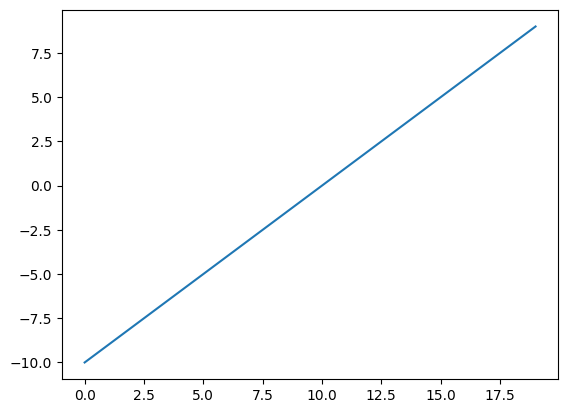

In [ ]:
A = torch.arange(-10 , 10 , 1)
plt.plot(A)

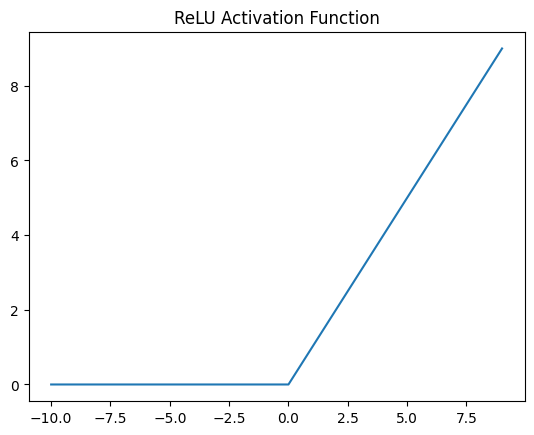

In [ ]:
relu = nn.ReLU()

out = relu(A)

plt.plot(A, out)
plt.title("ReLU Activation Function")
plt.show()

In [ ]:
def relu(x : torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0),x)
relu(A)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

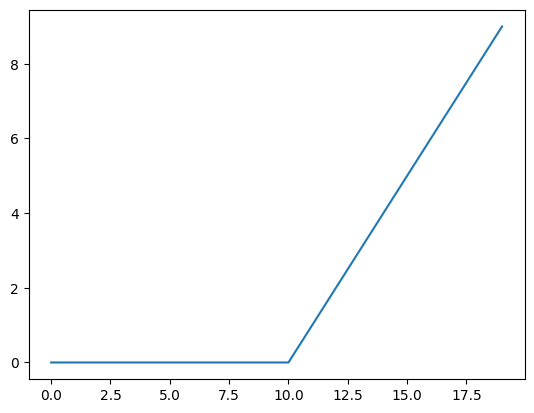

In [ ]:
plt.plot(relu(A))

In [ ]:
def sigmoid(x):
  return 1/(1 + torch.exp(-x))
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

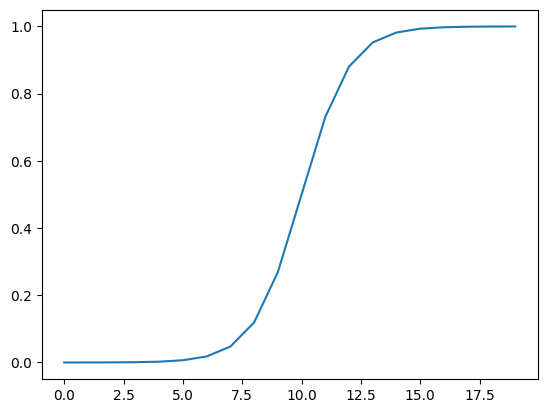

In [ ]:
plt.plot(sigmoid(A))

In [ ]:
from sklearn.datasets import make_blobs
X_blobs , y_blobs = make_blobs(n_samples=1000 , n_features=2 , centers=4 , cluster_std=1.5 , random_state=42)

In [ ]:
X_blobs = torch.from_numpy(X_blobs).type(torch.float)   # ویژگی‌ها باید float باشند
y_blobs = torch.from_numpy(y_blobs).type(torch.float)

In [ ]:
X_train , X_test , y_train , y_test = train_test_split(X_blobs ,y_blobs , test_size=0.2 , random_state=42 )

In [ ]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: torch.Size([800, 2])
Test shape: torch.Size([200, 2])


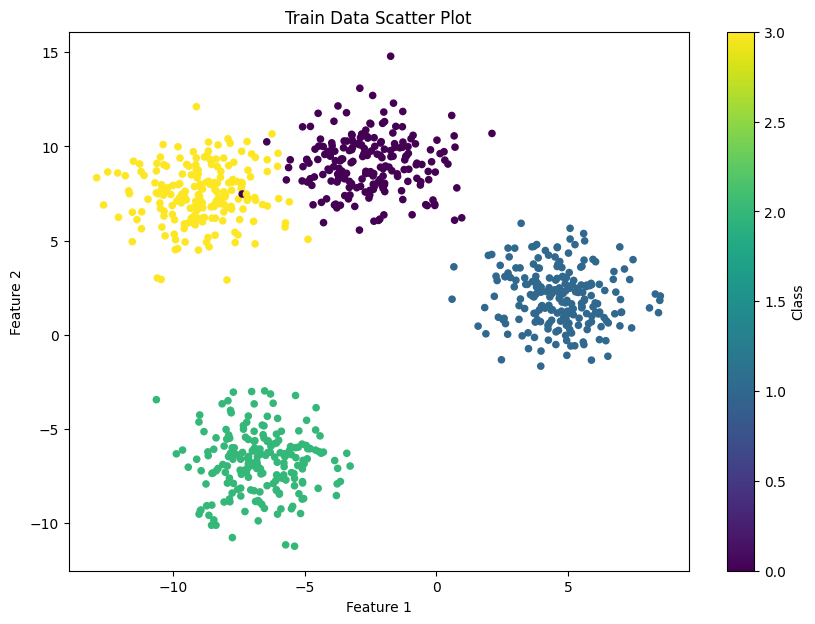

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(X_train[:,0], X_train[:,1], s=20, c=y_train, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Train Data Scatter Plot')
plt.colorbar(label='Class')
plt.show()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# class multi_classV0(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.layer_1 = nn.Linear(in_features=2 , out_features=20)
#     self.layer_2 = nn.Linear(in_features=20 , out_features=20)
#     self.layer_3 = nn.Linear(in_features=20 , out_features=4)
#     self.relu = nn.ReLU()
#   def forward(self , x : torch.Tensor) -> torch.Tensor:
#     return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


In [ ]:
class multi_classV0(nn.Module):
  def __init__(self,input_features,output_features,hidden_layer=20):
    super().__init__()
    self.Linear_stack = nn.Sequential(
        nn.Linear(in_features= input_features , out_features=hidden_layer),
        nn.ReLU(),
        nn.Linear(in_features= hidden_layer , out_features=hidden_layer),
        nn.ReLU(),
        nn.Linear(in_features= hidden_layer , out_features=output_features)

    )
  def forward(self , x) :
     return self.Linear_stack(x)
model_4 = multi_classV0(input_features=2 , output_features=4 , hidden_layer=20).to(device)
model_4

multi_classV0(
  (Linear_stack): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=4, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),lr= 0.1)

In [ ]:
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)
# X_train = X_train.to(device)
# X_test = X_test.to(device)
# y_train = y_train.to(device).long()
# y_test = y_test.to(device).long()
# epochs = 1000
# for epoch in range(epochs):
#   model_4.train()
#   y_logits = model_4(X_train).squeeze()
#   y_pred = torch.argmax(y_logits ,  dim=1)
#   loss = loss_fn(y_logits , y_train)
#   acc = ac_fn(y_train , y_pred)
#   optimizer.zero_grad()
#   loss.backward()
#   optimizer.step()
#   model_4.eval()
#   with torch.inference_mode():
#     y_test_predicted_logits = model_4(X_test).squeeze()
#     y_predicted = torch.argmax(y_test_predicted_logits , dim=1)
#     test_loss = loss_fn(y_test_predicted_logits , y_test)
#     acc_test = ac_fn(y_test , y_predicted)

#   if epoch % 100 == 0:
#         print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")


In [ ]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
y_train = y_train.to(device).long()
y_test = y_test.to(device).long()

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train)
    acc = ac_fn(y_train,
                      y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = ac_fn(y_test,
                             test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.41006, Acc: 24.25% | Test Loss: 1.13304, Test Acc: 47.50%
Epoch: 100 | Loss: 0.02993, Acc: 99.12% | Test Loss: 0.02146, Test Acc: 99.50%
Epoch: 200 | Loss: 0.02545, Acc: 99.25% | Test Loss: 0.01559, Test Acc: 99.50%
Epoch: 300 | Loss: 0.02422, Acc: 99.25% | Test Loss: 0.01367, Test Acc: 99.50%
Epoch: 400 | Loss: 0.02361, Acc: 99.25% | Test Loss: 0.01267, Test Acc: 99.50%
Epoch: 500 | Loss: 0.02318, Acc: 99.50% | Test Loss: 0.01202, Test Acc: 99.50%
Epoch: 600 | Loss: 0.02285, Acc: 99.50% | Test Loss: 0.01155, Test Acc: 99.50%
Epoch: 700 | Loss: 0.02256, Acc: 99.50% | Test Loss: 0.01117, Test Acc: 99.50%
Epoch: 800 | Loss: 0.02230, Acc: 99.50% | Test Loss: 0.01085, Test Acc: 99.50%
Epoch: 900 | Loss: 0.02206, Acc: 99.50% | Test Loss: 0.01056, Test Acc: 99.50%


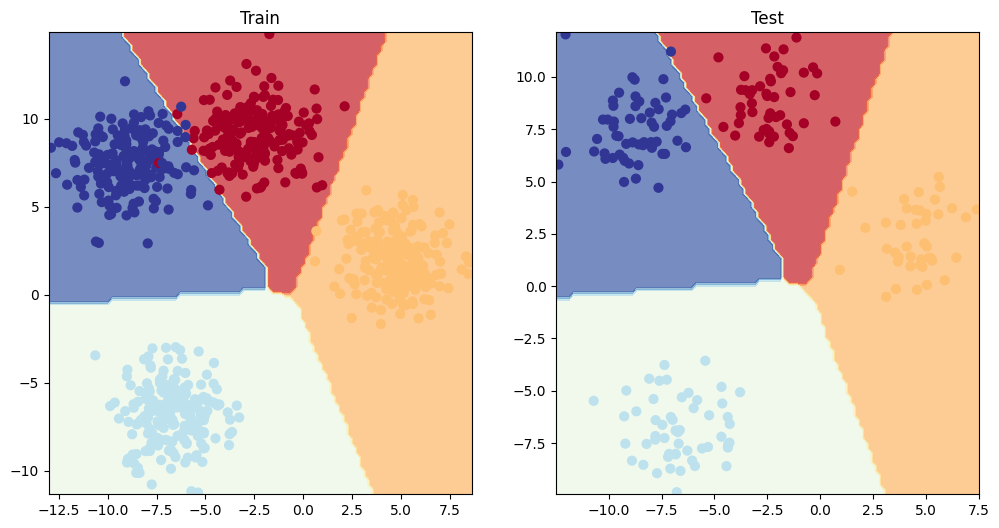

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_test, y_test) # model_3 = has non-linearity

In [ ]:
!pip install torchmetrics
from torchmetrics.classification import Accuracy

In [ ]:
accuracy = Accuracy(task="multiclass", num_classes=4).to(device)
print(accuracy(test_pred, y_test))

tensor(0.9950)
